                     image_id  adjudicated_dr_grade  adjudicated_dme  \
0  20051020_43808_0100_PP.png                   0.0              0.0   
1  20051020_43832_0100_PP.png                   1.0              0.0   
2  20051020_43882_0100_PP.png                   1.0              0.0   
3  20051020_43906_0100_PP.png                   2.0              1.0   
4  20051020_44261_0100_PP.png                   0.0              0.0   

   adjudicated_gradable  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  


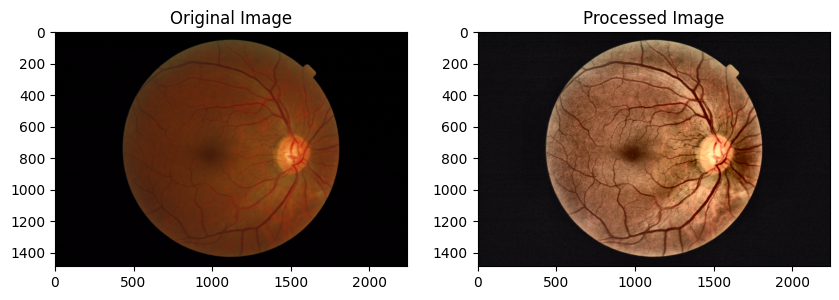

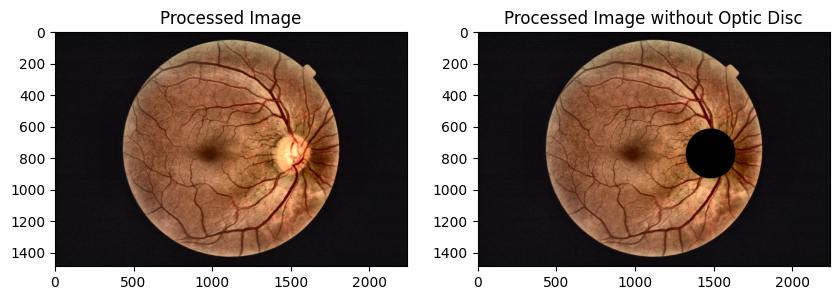

Processed 0 images...
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Processed 1200 images...
Processed 1300 images...
Processed 1400 images...
Processed 1500 images...
Processed 1600 images...
Processed 1700 images...
All images processed and saved in: /Users/pillala/Documents/capstone project/messidor-2/preprocessed_images_1/ and /Users/pillala/Documents/capstone project/messidor-2/segmented_images/


In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Reading the CSV file containing the metadata for images
csv_path = '/Users/pillala/Documents/capstone project/messidor-2/messidor_data.csv'  # Update this to the actual path of the CSV file
data = pd.read_csv(csv_path)

# Display the first few rows of the CSV file to confirm it's loaded correctly
print(data.head())

# Function to display images side by side for comparison
def display_images(image1, image2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.title(title2)
    
    plt.show()

# Function to apply Adaptive Histogram Equalization (AHE) to the image
def apply_ahe(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    ahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_yuv[:, :, 0] = ahe.apply(img_yuv[:, :, 0])
    img_ahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_ahe

# Function to apply Gamma Correction to the image
def apply_gamma_correction(img, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img, table)
    return img_gamma

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img_clahe = cv2.merge((l, a, b))
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_LAB2BGR)
    return img_clahe

# Preprocessing pipeline that sequentially applies AHE, Gamma Correction, and CLAHE
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img_ahe = apply_ahe(img)
    img_gamma = apply_gamma_correction(img_ahe, gamma=1.2)
    img_clahe = apply_clahe(img_gamma)
    
    if np.mean(img_clahe) < np.mean(img):
        img_clahe = cv2.rotate(img_clahe, cv2.ROTATE_180)
    
    return img, img_clahe

# Specify the input and output folders
image_folder = '/Users/pillala/Documents/capstone project/messidor-2/images'  # Update this to the actual path where images are stored
output_folder = '/Users/pillala/Documents/capstone project/messidor-2/preprocessed_images_1/'  # Update this to your desired output folder
segmented_folder = '/Users/pillala/Documents/capstone project/messidor-2/segmented_images/'  # Folder to save the segmented images

os.makedirs(output_folder, exist_ok=True)
os.makedirs(segmented_folder, exist_ok=True)

# Function to detect and segment the optic disc area by converting to grayscale and masking the brightest part
def remove_optic_disc(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    
    # Find the brightest region by applying a threshold
    _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask for the optic disc
    mask = np.ones(img.shape[:2], dtype="uint8") * 255  # Start with a white mask
    
    # If contours are found, draw the largest one (assumed to be the optic disc)
    if contours:
        # Find the largest contour by area
        max_contour = max(contours, key=cv2.contourArea)
        
        # Create a circular mask based on the largest contour
        x, y, w, h = cv2.boundingRect(max_contour)
        radius = int(1 * max(w, h))
        center = (x + w // 2, y + h // 2)
        cv2.circle(mask, center, radius, 0, -1)  # Draw a filled black circle on the mask
    
    # Apply the mask to the image to remove the optic disc
    img_no_disc = cv2.bitwise_and(img, img, mask=mask)
    return img_no_disc

# Function to preprocess and segment images in the dataset
def preprocess_and_segment_all_images(image_folder, output_folder, segmented_folder):
    for index, row in data.iterrows():
        image_id = row['image_id']
        image_path = os.path.join(image_folder, image_id)
        
        # Preprocess the image
        original_img, processed_img = preprocess_image(image_path)
        
        # Save the preprocessed image
        preprocessed_output_path = os.path.join(output_folder, image_id)
        cv2.imwrite(preprocessed_output_path, processed_img)
        
        # Remove the optic disc from the processed image
        img_no_disc = remove_optic_disc(processed_img)
        
        # Save the segmented image without the optic disc
        segmented_output_path = os.path.join(segmented_folder, image_id)
        cv2.imwrite(segmented_output_path, img_no_disc)

        # Display the images for the first entry
        if index == 0:
            display_images(original_img, processed_img, title1="Original Image", title2="Processed Image")
            display_images(processed_img, img_no_disc, title1="Processed Image", title2="Processed Image without Optic Disc")
        
        # Progress update for every 100 images
        if index % 100 == 0:
            print(f'Processed {index} images...')

# Execute preprocessing and segmentation
preprocess_and_segment_all_images(image_folder, output_folder, segmented_folder)

print(f'All images processed and saved in: {output_folder} and {segmented_folder}')

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Set parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Paths
CSV_PATH = '/Users/pillala/Documents/capstone project/messidor-2/messidor_data.csv'
SEGMENTED_FOLDER = '/Users/pillala/Documents/capstone project/messidor-2/segmented_images/'

# Load the CSV data
data = pd.read_csv(CSV_PATH)
print(data.head())

# Filter only gradable images
data = data[data['adjudicated_gradable'] == 1]

# Extract image paths and labels
image_paths = data['image_id'].apply(lambda x: os.path.join(SEGMENTED_FOLDER, x)).values
labels = data['adjudicated_dr_grade'].values

# One-hot encode the labels (for multi-class classification)
num_classes = len(np.unique(labels))
labels = to_categorical(labels, num_classes=num_classes)

# Function to load and preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize the image
    img = img_to_array(img) / 255.0  # Normalize the image
    return img

# Load and preprocess all images
X = np.array([preprocess_image(path) for path in image_paths])
y = np.array(labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the final model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=EPOCHS, batch_size=BATCH_SIZE)

# Save the trained model
model.save('mobilenetv2_dr_classification.h5')

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

                     image_id  adjudicated_dr_grade  adjudicated_dme  \
0  20051020_43808_0100_PP.png                   0.0              0.0   
1  20051020_43832_0100_PP.png                   1.0              0.0   
2  20051020_43882_0100_PP.png                   1.0              0.0   
3  20051020_43906_0100_PP.png                   2.0              1.0   
4  20051020_44261_0100_PP.png                   0.0              0.0   

   adjudicated_gradable  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.5246 - loss: 1.3381 - val_accuracy: 0.5874 - val_loss: 1.1374
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.5403 - loss: 1.1922 - val_accuracy: 0.6132 - val_loss: 1.0283
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5995 - loss: 1.0392 - val_accuracy: 0.6132 - val_loss: 0.9998
Epoch 4/50
44/44 ━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5993 - loss: 1.0274
Validation Loss: 1.0114102363586426
Validation Accuracy: 0.6131805181503296


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Load the CSV data (Update this path to your CSV file location)
csv_path = '/Users/pillala/Documents/capstone project/messidor-2/cleaned_messidor_data.csv'
data = pd.read_csv(csv_path)
data = data[data['adjudicated_gradable'] == 1]  # Filter out non-gradable images

# Extract image IDs and labels for DR severity classification
X = data['image_id'].values
y = data['adjudicated_dr_grade'].values

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Define ImageDataGenerators for training and testing datasets
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to generate data batches from the file paths and labels
def generate_data_from_paths(image_folder, image_ids, labels, datagen, batch_size, target_size=(img_height, img_width)):
    image_paths = [os.path.join(image_folder, img_id) for img_id in image_ids]
    label_array = np.array(labels)

    while True:
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)
        
        for start_idx in range(0, len(image_paths), batch_size):
            end_idx = min(start_idx + batch_size, len(image_paths))
            batch_indices = indices[start_idx:end_idx]

            batch_images = []
            batch_labels = []

            for idx in batch_indices:
                img_path = image_paths[idx]
                img = cv2.imread(img_path)
                img = cv2.resize(img, target_size)
                img = img.astype('float32') / 255.0
                batch_images.append(img)
                batch_labels.append(label_array[idx])

            yield np.array(batch_images), np.array(batch_labels)

# Specify the folder for preprocessed images
image_folder = '/Users/pillala/Documents/capstone project/messidor-2/segmented_images'

# Create data generators for training and validation
train_generator = generate_data_from_paths(image_folder, X_train, y_train, train_datagen, batch_size)
validation_generator = generate_data_from_paths(image_folder, X_test, y_test, test_datagen, batch_size)

# Build the Proposed DFNN Model with LOA Strategy
def build_dfnn_model(input_shape, num_classes=5):
    model = Sequential([
        # Layer 1
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 2
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 3
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 4
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Layer 5
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.1),  # Dropout value as per the document
        Dense(128, activation='relu'),
        Dropout(0.1),

        # Output Layer for DR Severity Classes
        Dense(num_classes, activation='softmax')
    ])
    return model

# Define the DFNN model with the input shape
input_shape = (img_height, img_width, 3)
dfnn_model = build_dfnn_model(input_shape)

# Compile the model initially before LOA optimization
dfnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initial training for a few epochs to get baseline performance
initial_history = dfnn_model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) // batch_size, 
    epochs=10,  # Initial epochs before LOA fine-tuning
    validation_data=validation_generator, 
    validation_steps=len(X_test) // batch_size
)

# Lion Optimization Algorithm Implementation
def lion_optimization_algorithm(model, train_generator, val_generator, epochs=50, batch_size=32, pride_size=5):
    """
    Implement the Lion Optimization Algorithm (LOA) to optimize the DFNN model.
    Args:
        model: The neural network model to be optimized.
        train_generator: Training data generator.
        val_generator: Validation data generator.
        epochs: Number of epochs for LOA optimization.
        batch_size: Batch size for training.
        pride_size: Number of lions in the pride.
    """
    # Initialize variables
    best_weights = model.get_weights()
    best_val_accuracy = 0.0
    lion_population = [model.get_weights() for _ in range(pride_size)]  # Initialize a pride of lions (set of model weights)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Pride Tuning: Simulate each lion's hunt and evaluate fitness
        for i in range(len(lion_population)):
            model.set_weights(lion_population[i])
            model.fit(train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=1, verbose=0)

            # Evaluate lion's performance on validation data
            val_loss, val_accuracy = model.evaluate(val_generator, steps=len(X_test) // batch_size, verbose=0)
            
            # Check if this lion is the dominant lion (best weights)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_weights = model.get_weights()
                print(f"New dominant lion found: Lion {i + 1}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Lion and Prey Tuning: Move lions towards the dominant lion's position or explore new solutions
        for i in range(len(lion_population)):
            if np.random.rand() < 0.5:  # Probability-based move towards the dominant lion
                # Move lion towards dominant lion (exploitation strategy)
                lion_population[i] = [dominant + 0.1 * (dominant - lion) for lion, dominant in zip(lion_population[i], best_weights)]
            else:
                # Random exploration of new prey (exploration strategy)
                lion_population[i] = [lion + 0.05 * np.random.randn(*lion.shape) for lion in lion_population[i]]
    
    # Set model weights to the best weights found by LOA
    model.set_weights(best_weights)
    print(f"Best Validation Accuracy Achieved by LOA: {best_val_accuracy:.4f}")
    return model

# Apply the Lion Optimization Algorithm to fine-tune the DFNN model
dfnn_model_loa_optimized = lion_optimization_algorithm(dfnn_model, train_generator, validation_generator, epochs=50, batch_size=batch_size)

# Evaluate the LOA-optimized model on the test set
test_loss, test_accuracy = dfnn_model_loa_optimized.evaluate(validation_generator, steps=len(X_test) // batch_size, verbose=0)
print(f'Final Test Accuracy with LOA Optimization: {test_accuracy:.2f}')

# Plotting the accuracy and loss trends (after LOA optimization)
plt.figure(figsize=(12, 6))
plt.plot(initial_history.history['accuracy'], label='Initial Training Accuracy')
plt.plot(initial_history.history['val_accuracy'], label='Initial Validation Accuracy')
plt.title('Initial Training Accuracy for DFNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/opt/anaconda3/envs/gg2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-14 10:15:38.416817: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-14 10:15:38.416840: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-10-14 10:15:38.416842: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-10-14 10:15:38.416872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-14 10:15:38.416880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.

Epoch 1/10


2024-10-14 10:15:40.381148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 954ms/step - accuracy: 0.5121 - loss: 1.2689 - val_accuracy: 0.5859 - val_loss: 1.2435
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 897ms/step - accuracy: 0.5716 - loss: 1.1697 - val_accuracy: 0.5732 - val_loss: 1.1510
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 840ms/step - accuracy: 0.5764 - loss: 1.1320 - val_accuracy: 0.6016 - val_loss: 1.0629
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 697ms/step - accuracy: 0.5846 - loss: 1.0921 - val_accuracy: 0.5732 - val_loss: 1.0471
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 558ms/step - accuracy: 0.5840 - loss: 1.0753 - val_accuracy: 0.5732 - val_loss: 1.0623
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 685ms/step - accuracy: 0.6021 - loss: 1.0833 - val_accuracy: 0.6565 - val_loss: 0.9870
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 700ms/step - accuracy: 0.6050 - loss: 1.0581 - val_accuracy: 0.6016 - val_loss: 1.0471
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 692ms/step - accuracy: 0.5874 - loss: 1.0589 - val_accuracy: 0.601

KeyboardInterrupt: 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Load the CSV data
csv_path = '/Users/pillala/Documents/capstone project/messidor-2/cleaned_messidor_data.csv'
data = pd.read_csv(csv_path)
data = data[data['adjudicated_gradable'] == 1]

# Extract image IDs and labels for DR severity classification
X = data['image_id'].values
y = data['adjudicated_dr_grade'].values

# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define image dimensions and batch size
img_height, img_width = 256, 256
batch_size = 32

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to generate data batches
def generate_data_from_paths(image_folder, image_ids, labels, datagen, batch_size, target_size=(img_height, img_width)):
    image_paths = [os.path.join(image_folder, img_id) for img_id in image_ids]
    label_array = np.array(labels)
    while True:
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)
        for start_idx in range(0, len(image_paths), batch_size):
            end_idx = min(start_idx + batch_size, len(image_paths))
            batch_indices = indices[start_idx:end_idx]
            batch_images = []
            batch_labels = []
            for idx in batch_indices:
                img_path = image_paths[idx]
                img = cv2.imread(img_path)
                img = cv2.resize(img, target_size)
                img = img.astype('float32') / 255.0
                batch_images.append(img)
                batch_labels.append(label_array[idx])
            yield np.array(batch_images), np.array(batch_labels)

# Specify image folder
image_folder = '/Users/pillala/Documents/capstone project/messidor-2/segmented_images'

# Create data generators
train_generator = generate_data_from_paths(image_folder, X_train, y_train, train_datagen, batch_size)
validation_generator = generate_data_from_paths(image_folder, X_test, y_test, test_datagen, batch_size)

# Build DFNN model
def build_dfnn_model(input_shape, num_classes=5):
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (img_height, img_width, 3)
dfnn_model = build_dfnn_model(input_shape)
dfnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initial training
initial_history = dfnn_model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) // batch_size, 
    epochs=10,  # Initial epochs before LOA fine-tuning
    validation_data=validation_generator, 
    validation_steps=len(X_test) // batch_size
)

# Lion Optimization Algorithm Implementation
def lion_optimization_algorithm(model, train_generator, val_generator, epochs=50, batch_size=32, pride_size=5):
    best_weights = model.get_weights()
    best_val_accuracy = 0.0
    lion_population = [model.get_weights() for _ in range(pride_size)]
    loa_train_acc = []
    loa_val_acc = []

    for epoch in range(epochs):
        print(f"LOA Epoch {epoch + 1}/{epochs}")
        epoch_train_acc = []
        epoch_val_acc = []
        
        for i in range(len(lion_population)):
            model.set_weights(lion_population[i])
            history = model.fit(train_generator, steps_per_epoch=len(X_train) // batch_size, epochs=1, verbose=0)
            val_loss, val_accuracy = model.evaluate(val_generator, steps=len(X_test) // batch_size, verbose=0)
            
            epoch_train_acc.append(history.history['accuracy'][0])
            epoch_val_acc.append(val_accuracy)
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_weights = model.get_weights()
                print(f"New dominant lion: Lion {i + 1}, Validation Accuracy: {val_accuracy:.4f}")
        
        loa_train_acc.append(np.mean(epoch_train_acc))
        loa_val_acc.append(np.mean(epoch_val_acc))

        for i in range(len(lion_population)):
            if np.random.rand() < 0.5:
                lion_population[i] = [dominant + 0.1 * (dominant - lion) for lion, dominant in zip(lion_population[i], best_weights)]
            else:
                lion_population[i] = [lion + 0.05 * np.random.randn(*lion.shape) for lion in lion_population[i]]
    
    model.set_weights(best_weights)
    return model, loa_train_acc, loa_val_acc

# Apply the Lion Optimization Algorithm
dfnn_model_loa_optimized, loa_train_acc, loa_val_acc = lion_optimization_algorithm(
    dfnn_model, train_generator, validation_generator, epochs=50, batch_size=batch_size)

# Evaluate the LOA-optimized model
test_loss, test_accuracy = dfnn_model_loa_optimized.evaluate(validation_generator, steps=len(X_test) // batch_size, verbose=0)
print(f'Final Test Accuracy with LOA Optimization: {test_accuracy:.2f}')

# Plotting the accuracy trends for DFNN and LOA
plt.figure(figsize=(12, 6))
plt.plot(initial_history.history['accuracy'], label='Initial Training Accuracy (DFNN)')
plt.plot(initial_history.history['val_accuracy'], label='Initial Validation Accuracy (DFNN)')
plt.plot(loa_train_acc, label='LOA Training Accuracy')
plt.plot(loa_val_acc, label='LOA Validation Accuracy')
plt.title('Training and Validation Accuracy (DFNN and LOA)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/opt/anaconda3/envs/gg2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 957ms/step - accuracy: 0.4699 - loss: 1.3351 - val_accuracy: 0.5820 - val_loss: 1.1461
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 940ms/step - accuracy: 0.5907 - loss: 1.2086 - val_accuracy: 0.5935 - val_loss: 1.1271
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 850ms/step - accuracy: 0.5542 - loss: 1.1822 - val_accuracy: 0.5732 - val_loss: 1.1540
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 710ms/step - accuracy: 0.5953 - loss: 1.1243 - val_accuracy: 0.5894 - val_loss: 1.1196
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 566ms/step - accuracy: 0.6065 - loss: 1.1075 - val_accuracy: 0.5732 - val_loss: 1.1447
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 688ms/step - accuracy: 0.5647 - loss: 1.1698 - val_accuracy: 0.5711 - val_loss: 1.1076
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 679ms/step - accuracy: 0.5774 - loss: 1.1342 - val_accuracy: 0.5935 - val_loss: 1.0316
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 680ms/step - accuracy: 0.5611 - loss: 1.0822 - val_accu

KeyboardInterrupt: 

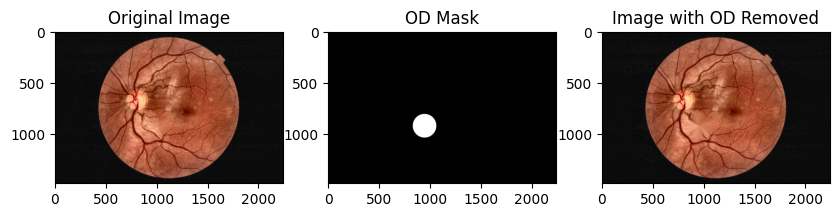

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to localize the OD using morphological operations and intensity thresholding
def localize_od(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(gray)
    
    # Thresholding based on intensity values to focus on bright regions (OD)
    _, thresh = cv2.threshold(enhanced_img, 220, 255, cv2.THRESH_BINARY)

    # Perform morphological operations to enhance large bright areas (OD)
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours to identify the largest bright circular area
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty mask
    mask = np.zeros_like(gray)
    
    # Find the largest contour, assuming it's the OD
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Fit a minimum enclosing circle to the contour
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    center = (int(x), int(y))
    radius = int(radius)
    
    # Draw the circle on the mask
    cv2.circle(mask, center, radius, 255, -1)
    
    return mask

# Function to subtract OD from the image
def subtract_od(image, mask):
    # Subtract the OD region from the original image
    result = cv2.inpaint(image, mask, 7, cv2.INPAINT_TELEA)
    return result

# Load the preprocessed image (apply CLAHE, AHE, and Gamma Correction)
image_path = '/Users/pillala/Documents/capstone project/messidor-2/preprocessed_images_1/IM004737.jpg'
image = cv2.imread(image_path)

# Localize and subtract the OD
od_mask = localize_od(image)
od_removed_image = subtract_od(image, od_mask)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title('OD Mask')
plt.imshow(od_mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Image with OD Removed')
plt.imshow(cv2.cvtColor(od_removed_image, cv2.COLOR_BGR2RGB))

plt.show()

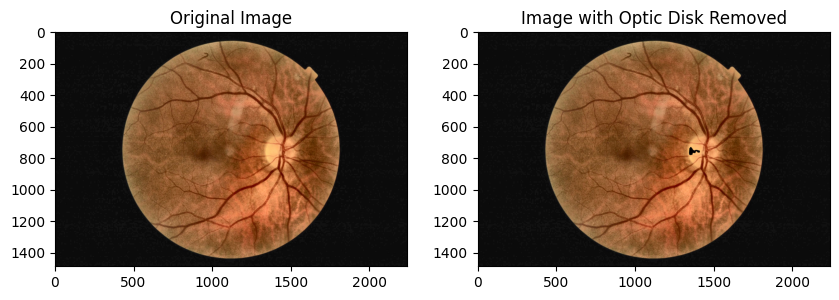

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def optic_disk_localization(image, kernel_size=15, threshold=0.8):
    """
    Function to localize and remove the optic disk from a retinal fundus image.
    :param image: Input pre-processed retinal image (color image)
    :param kernel_size: Size of the kernel for smoothing and segmentation
    :param threshold: Threshold for optic disk area detection
    :return: Image with optic disk localized and removed
    """
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to smooth the image for better OD detection
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

    # Use adaptive thresholding to identify bright regions (optic disk and similar)
    _, thresh_image = cv2.threshold(blurred_image, int(threshold * 255), 255, cv2.THRESH_BINARY)

    # Use morphological operations to highlight the optic disk
    kernel = np.ones((5, 5), np.uint8)
    morphed_image = cv2.morphologyEx(thresh_image, cv2.MORPH_CLOSE, kernel)

    # Find contours in the morphed image
    contours, _ = cv2.findContours(morphed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour corresponds to the optic disk
    max_contour = max(contours, key=cv2.contourArea)
    
    # Create a mask for the optic disk area
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [max_contour], -1, (255), thickness=-1)

    # Subtract optic disk area from the original image
    result_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))

    return result_image, mask

# Load sample retinal image (change the path to your image file)
image = cv2.imread('/Users/pillala/Documents/capstone project/messidor-2/preprocessed_images_1/IM004621.jpg')

# Localize and remove the optic disk
result_image, optic_disk_mask = optic_disk_localization(image)

# Display the original image and the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Image with Optic Disk Removed")
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

plt.show()

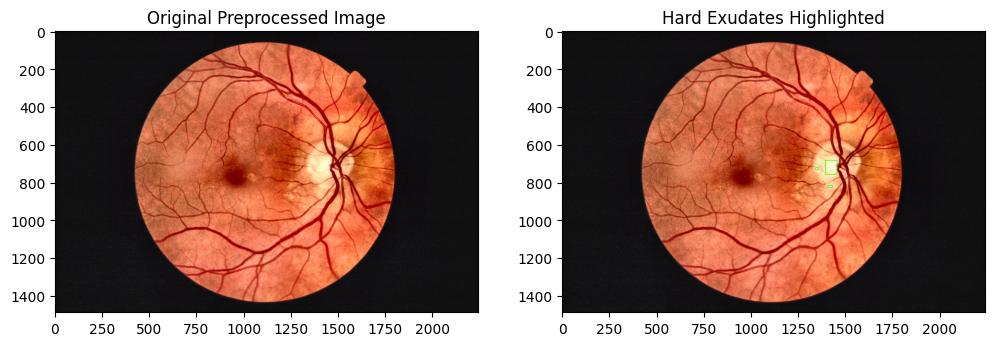

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the preprocessed fundus image
image_path = "/Users/pillala/Documents/capstone project/messidor-2/preprocessed_images_1/20051020_43882_0100_PP.png"
img = cv2.imread(image_path)

# Step 1: Convert to Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 2: Apply CLAHE to enhance bright regions (exudates)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(gray)

# Step 3: Apply Thresholding to isolate bright regions
_, thresh = cv2.threshold(enhanced_img, 250, 255, cv2.THRESH_BINARY)

# Step 4: Use Morphological Operations to clean small noise
kernel = np.ones((3, 3), np.uint8)
morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# Step 5: Find contours of the exudates
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 6: Highlight the detected hard exudates on the original image
highlighted_img = img.copy()
for contour in contours:
    if cv2.contourArea(contour) > 20:  # Filter small contours (noise)
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box

# Display the original and highlighted images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Preprocessed Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(highlighted_img, cv2.COLOR_BGR2RGB))
plt.title("Hard Exudates Highlighted")

plt.show()